## Model Definition

At the top level, our model is an "assembly" that comprises of two binary classifiers; one to predict on infected/non-infected, and one to predict on covid/non-covid.

Each binary classifier is itself an ensemble model that consists of ten individual CNN models. We will begin our exploration with this baseline CNN model.

The CNN model is highly customizable, and is populated with sane defaults that we have empirically found to be best performing. All models are defined in the `models` module.

In [1]:
import learn, models, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
cnn = models.CNN()
print(cnn)

CNN(
  (layers): Sequential(
    (0): Convolutional(
      (layers): Sequential(
        (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01)
        (6): Conv2d(10, 15, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        (7): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): LeakyReLU(negative_slope=0.01)
        (9): AdaptiveMaxPool2d(output_size=(27, 27))
        (10): Flatten(start_dim=1, end_dim=-1)
      )
    )
    (1): Classifier(
      (layers): Sequential(
        (0): Linear(in_features=10935, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, mom

## Model Training and Evaluation

Model training and testing is done with the `learn` module. Both functionalities are exported in the `run` function.

When training, the progress of the model (train/test loss and accuracy curves) is automatically saved in a `progress.json` file. The best-performing model on the test set (based on the metric of Acc. + Sens. - 0.5|Acc. - Sens.|) is also saved in a model file.

In [3]:
# Train the CNN for 5 epochs on 75% of the infected/normal training set, and save it a basic-inf-cnn.model file

learn.run(
    cnn,
    "inf",
    N_EPOCH=5,
    prop=0.75,
    name="basic-inf-cnn",
    save="basic-inf-cnn.model"
)

Beginning training of basic-inf-cnn with
    N_EPOCH  5
     L_RATE  5e-05
    W_DECAY  0.01

+--------+--------+--------+--------+
|        |    Acc.|    Loss|   Sens.|
+--------+--------+--------+--------+
|   Train|     N/A|     N/A|     N/A|
|    Test| 61.951%| 0.68970| 100.000%|
+--------+--------+--------+--------+

--- Beginning Epoch 1/5 @ 2021-03-20 10:27:53.754755
100%|██████████| 123/123 [00:07<00:00, 16.34it/s]
--- Completed Epoch 1/5 @ 2021-03-20 10:28:01.642011

+--------+--------+--------+--------+
|        |    Acc.|    Loss|   Sens.|
+--------+--------+--------+--------+
|   Train| 91.130%| 0.24927| 92.487%|
|    Test| 71.057%| 0.68099| 99.475%|
+--------+--------+--------+--------+
Model saved in 'basic-inf-cnn.model' @ 2021-03-20 10:28:02.419008

--- Beginning Epoch 2/5 @ 2021-03-20 10:28:02.420010
100%|██████████| 123/123 [00:07<00:00, 15.66it/s]
--- Completed Epoch 2/5 @ 2021-03-20 10:28:10.282767

+--------+--------+--------+--------+
|        |    Acc.|    Loss| 

In [4]:
# Now test the CNN on the validation set

learn.run(
    cnn,
    "inf",
    test_with="val"
)

Evaluating CNN

+--------+--------+--------+--------+
|        |    Acc.|    Loss|   Sens.|
+--------+--------+--------+--------+
|   Train|     N/A|     N/A|     N/A|
|    Test| 80.000%| 0.39512| 100.000%|
+--------+--------+--------+--------+


The following function shows the general procedure to train a set of ensemble models.

In [5]:
def train_ensemble(class_type, name, params={}, num_models=10, **kwargs):
    ens = [models.CNN(**params) for _ in range(num_models)]
    for ind, model in enumerate(ens):
        learn.run(
            model,
            class_type,
            N_EPOCH=20,
            prop=0.75,
            name=f"{name}-{ind+1}",
            save=f"{name}-{ind+1}.model",
            **kwargs
        )

# Infected/normal ensemble
# train_ensemble("inf", "ens-inf", params={
#     "L_RATE": 2.3e-6,
#     "W_DECAY": 5e-3,
#     "L_WEIGHTS": [0.25, 0.75]
# })

# Covid/non-covid ensemble
# train_ensemble("cov", "ens-cov", params={
#     "L_RATE": 1e-5,
#     "W_DECAY": 5e-3,
#     "L_WEIGHTS": [0.65, 0.35]
# })

# Ternary ensemble
# train_ensemble("all", "ens-all")

The trained ensemble models for each type of classifier are exported by the `ensemble_for` method. The trained two-part binary classifier is exported by the `Assembly` class (which itself uses the infected/non-infected and covid/non-covid ensemble classifiers).

In [6]:
tern_model = models.ensemble_for("all")
bin_model = models.Assembly()

In [7]:
from utils import load_data
from transforms import clean_transform

val_loader = load_data(kind="val", transform=clean_transform)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(model):
    def sensitivity(results):
        labels = models.labels.get("all")
        inf_labels = [labels["infected/non-covid"], labels["infected/covid"]]
        infected = list(filter(lambda x: x[1] in inf_labels, results))
        covid = list(filter(lambda x: x[1] == labels["infected/covid"], results))
        return {
            "infected": sum([1 for pred, target in infected if pred in inf_labels])/len(infected),
            "covid": sum([1 for pred, target in covid if pred == target])/len(covid)
        }
    labels_inv = models.labels_inv.get("all")
    fig, axs = plt.subplots(5, 5)
    fig.set_size_inches(15, 15)
    results = []
    for ind, (data, target) in enumerate(val_loader):
        ax = axs[ind//5][ind % 5]
        ax.imshow(data[0][0], cmap="gray")
        data = data.to(device)
        pred = torch.argmax(model(data)).item()
        target = target.item()
        results.append((pred, target))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Actual: {labels_inv.get(target).capitalize()}\nPredicted: {labels_inv.get(pred).capitalize()}")
    sens = sensitivity(results)
    acc = sum([1 for pred, target in results if pred == target])/len(results)
    fig.suptitle(f"Accuracy: {acc*100:.1f}%\nInfected Sensitivity: {sens['infected']*100:.1f}%\nCovid Sensitivity: {sens['covid']*100:.1f}%", fontsize=20)
    plt.show()

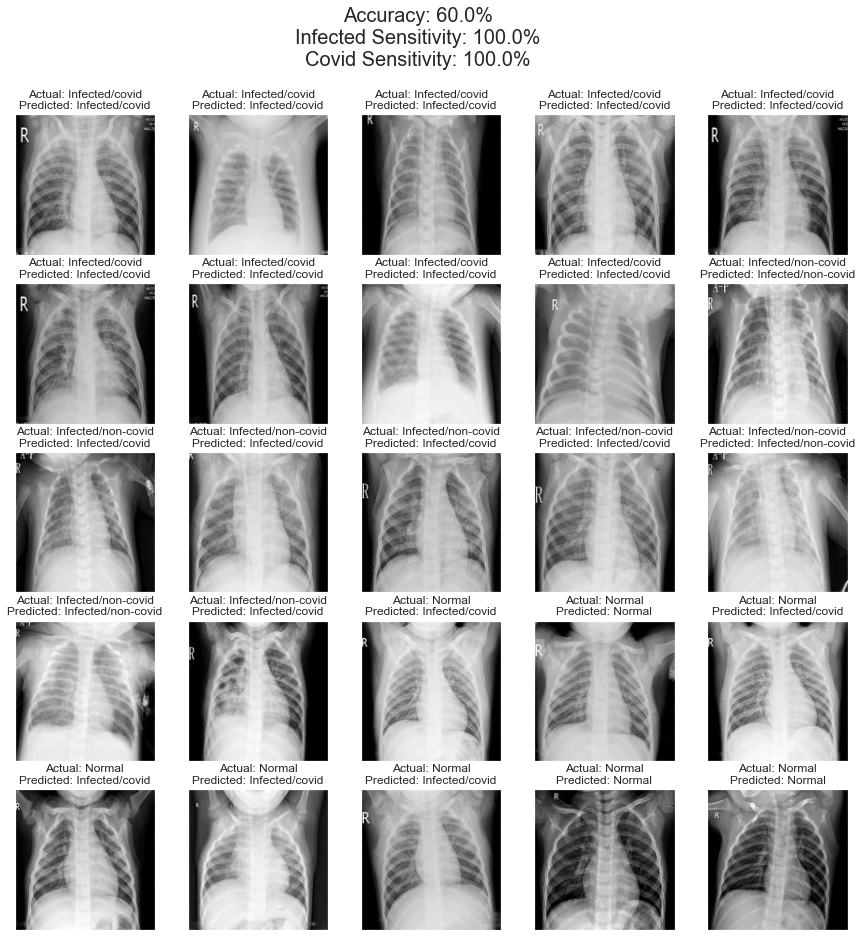

In [8]:
evaluate(tern_model)

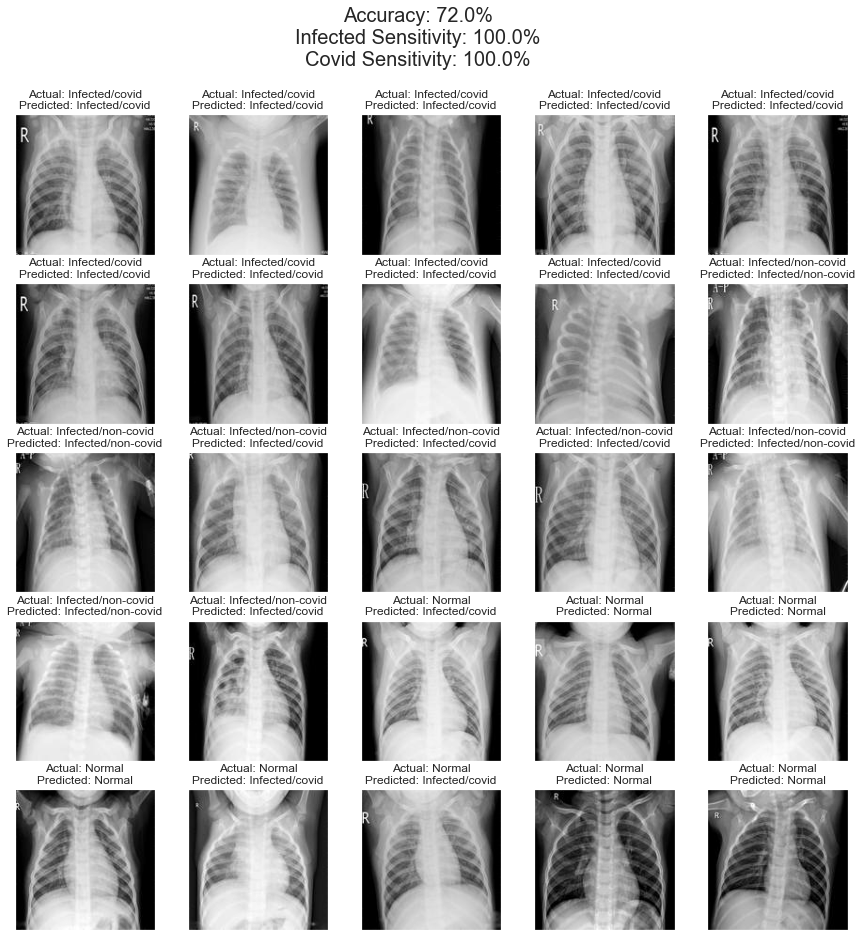

In [9]:
evaluate(bin_model)